In [53]:
import pandas as pd

import matplotlib.pyplot as plt
from scipy.stats import linregress
import json
from __future__ import annotations
import os
import time
import math
import typing as t
from datetime import datetime, timedelta, timezone

import requests
from dateutil import parser as dateparser

API_BASE = os.environ.get("KALSHI_API_BASE", "https://api.elections.kalshi.com/trade-api/v2")

def to_unix_ts(x: t.Union[str, datetime]) -> int:
    """Convert a datetime or ISO/date string to UNIX seconds (UTC)."""
    if isinstance(x, (int, float)):
        return int(x)
    if isinstance(x, str):
        # Accept 'YYYY-MM-DD', ISO8601, or relative strings like '-30d' or 'now'
        s = x.strip().lower()
        if s == "now":
            return int(datetime.now(timezone.utc).timestamp())
        if s.startswith("-") and s.endswith("d"):
            days = int(s[1:-1])
            dt = datetime.now(timezone.utc) - timedelta(days=days)
            return int(dt.timestamp())
        dt = dateparser.parse(s)
        if dt.tzinfo is None:
            dt = dt.replace(tzinfo=timezone.utc)
        else:
            dt = dt.astimezone(timezone.utc)
        return int(dt.timestamp())
    if isinstance(x, datetime):
        if x.tzinfo is None:
            x = x.replace(tzinfo=timezone.utc)
        else:
            x = x.astimezone(timezone.utc)
        return int(x.timestamp())
    raise TypeError(f"Unsupported timestamp type: {type(x)}")

def get_json(url: str, params: dict | None = None) -> dict:
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def get_market(market_ticker: str) -> dict:
    url = f"{API_BASE}/markets/{market_ticker}"
    return get_json(url)["market"]

def get_event(event_ticker: str) -> dict:
    url = f"{API_BASE}/events/{event_ticker}"
    return get_json(url)["event"]

def get_market_candles(series_ticker: str, market_ticker: str, start_ts: int, end_ts: int, period_minutes: int = 1440) -> dict:
    if period_minutes not in (1, 60, 1440):
        raise ValueError("period_minutes must be one of 1, 60, or 1440")
    url = f"{API_BASE}/series/{series_ticker}/markets/{market_ticker}/candlesticks"
    params = {"start_ts": start_ts, "end_ts": end_ts, "period_interval": period_minutes}
    return get_json(url, params=params)

def candles_to_df(payload: dict) -> pd.DataFrame:
    c = payload.get("candlesticks", [])
    if not c:
        return pd.DataFrame(columns=[
            "end_period_ts","end_time","yes_bid_open","yes_bid_high","yes_bid_low","yes_bid_close",
            "yes_ask_open","yes_ask_high","yes_ask_low","yes_ask_close",
            "price_open","price_high","price_low","price_close","price_mean","price_previous","price_min","price_max",
            "volume","open_interest","price_close_prob"
        ])
    rows = []
    for row in c:
        end_ts = row.get("end_period_ts")
        end_time = pd.to_datetime(end_ts, unit="s", utc=True)
        price = row.get("price", {})
        yes_bid = row.get("yes_bid", {})
        yes_ask = row.get("yes_ask", {})
        rows.append({
            "end_period_ts": end_ts,
            "end_time": end_time,
            "yes_bid_open": yes_bid.get("open"),
            "yes_bid_high": yes_bid.get("high"),
            "yes_bid_low": yes_bid.get("low"),
            "yes_bid_close": yes_bid.get("close"),
            "yes_ask_open": yes_ask.get("open"),
            "yes_ask_high": yes_ask.get("high"),
            "yes_ask_low": yes_ask.get("low"),
            "yes_ask_close": yes_ask.get("close"),
            "price_open": price.get("open"),
            "price_high": price.get("high"),
            "price_low": price.get("low"),
            "price_close": price.get("close"),
            "price_mean": price.get("mean"),
            "price_previous": price.get("previous"),
            "price_min": price.get("min"),
            "price_max": price.get("max"),
            "volume": row.get("volume"),
            "open_interest": row.get("open_interest"),
            # convenience: convert close price in cents to probability 0-1
            "price_close_prob": (price.get("close") / 100) if price.get("close") is not None else None,
        })
    df = pd.DataFrame(rows).sort_values("end_time").reset_index(drop=True)
    return df

print("Helpers loaded. Base:", API_BASE)


Helpers loaded. Base: https://api.elections.kalshi.com/trade-api/v2


In [54]:
# Set time window
START = "-60d"  # last 60 days
END = "now"

# Define the two market tickers (our "pair")
TICKER_X = "KXSPACEXCOUNT-25-140"  # This will be our 'X' variable
TICKER_Y = "KXHURCTOTMAJ-25DEC01-T5"  # This will be our 'Y' variable

# Get series ticker for both markets
mk_x = get_market(TICKER_X)
evt_x = get_event(mk_x["event_ticker"])
series_ticker_x = evt_x["series_ticker"]

mk_y = get_market(TICKER_Y)
evt_y = get_event(mk_y["event_ticker"])
series_ticker_y = evt_y["series_ticker"]

print(f"Series for X: {series_ticker_x}")
print(f"Series for Y: {series_ticker_y}")

# Convert time window to timestamps
start_ts = to_unix_ts(START)
end_ts = to_unix_ts(END)
print(f"Window UTC: {datetime.fromtimestamp(start_ts, timezone.utc)} -> {datetime.fromtimestamp(end_ts, timezone.utc)}")

# Download 1-minute candle data for both tickers
print(f"\nDownloading data for {TICKER_X}...")
payload_x = get_market_candles(series_ticker_x, TICKER_X, start_ts, end_ts, period_minutes=60)
df_x = candles_to_df(payload_x)
print(f"Got {len(df_x)} rows for {TICKER_X}")

print(f"\nDownloading data for {TICKER_Y}...")
payload_y = get_market_candles(series_ticker_y, TICKER_Y, start_ts, end_ts, period_minutes=60)
df_y = candles_to_df(payload_y)
print(f"Got {len(df_y)} rows for {TICKER_Y}")


Series for X: KXSPACEXCOUNT
Series for Y: KXHURCTOTMAJ
Window UTC: 2025-09-16 21:40:25+00:00 -> 2025-11-15 21:40:25+00:00

Got 993 rows for KXSPACEXCOUNT-25-140

Got 1409 rows for KXHURCTOTMAJ-25DEC01-T5


In [55]:
df_y.head()

,end_period_ts,end_time,yes_bid_open,yes_bid_high,yes_bid_low,yes_bid_close,yes_ask_open,yes_ask_high,yes_ask_low,yes_ask_close,...,price_high,price_low,price_close,price_mean,price_previous,price_min,price_max,volume,open_interest,price_close_prob
0,1758060000,2025-09-16 22:00:00+00:00,1,1,1,1,8,8,8,8,...,NaN,NaN,NaN,NaN,9,None,None,0,1652,NaN
1,1758063600,2025-09-16 23:00:00+00:00,1,1,1,1,8,8,8,8,...,NaN,NaN,NaN,NaN,9,None,None,0,1652,NaN
2,1758067200,2025-09-17 00:00:00+00:00,1,1,1,1,8,8,8,8,...,NaN,NaN,NaN,NaN,9,None,None,0,1652,NaN
3,1758070800,2025-09-17 01:00:00+00:00,1,1,0,1,8,8,8,8,...,NaN,NaN,NaN,NaN,9,None,None,0,1652,NaN
4,1758074400,2025-09-17 02:00:00+00:00,1,1,1,1,8,8,8,8,...,NaN,NaN,NaN,NaN,9,None,None,0,1652,NaN


In [56]:
df_x.head()

,end_period_ts,end_time,yes_bid_open,yes_bid_high,yes_bid_low,yes_bid_close,yes_ask_open,yes_ask_high,yes_ask_low,yes_ask_close,...,price_high,price_low,price_close,price_mean,price_previous,price_min,price_max,volume,open_interest,price_close_prob
0,1758060000,2025-09-16 22:00:00+00:00,88,88,88,88,94,94,94,94,...,NaN,NaN,NaN,NaN,90,None,None,0,7659,NaN
1,1758063600,2025-09-16 23:00:00+00:00,88,88,88,88,94,94,94,94,...,NaN,NaN,NaN,NaN,90,None,None,0,7659,NaN
2,1758067200,2025-09-17 00:00:00+00:00,88,88,88,88,94,94,94,94,...,NaN,NaN,NaN,NaN,90,None,None,0,7659,NaN
3,1758070800,2025-09-17 01:00:00+00:00,88,88,88,88,94,94,94,94,...,NaN,NaN,NaN,NaN,90,None,None,0,7659,NaN
4,1758074400,2025-09-17 02:00:00+00:00,88,88,88,88,94,94,94,94,...,NaN,NaN,NaN,NaN,90,None,None,0,7659,NaN


In [57]:
df_x.columns == df_y.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [58]:
# Create a full aligned time series covering the union of both time ranges
# This ensures we have an even time-series where residuals exist for overlapping periods

# Get the union of all timestamps
all_times = pd.concat([
    df_x[['end_time']],
    df_y[['end_time']]
]).drop_duplicates().sort_values('end_time').reset_index(drop=True)

# Create a base dataframe with all timestamps
df_aligned = pd.DataFrame({'end_time': all_times['end_time']})

# Merge X and Y data, keeping all timestamps
df_aligned = df_aligned.merge(
    df_x[['end_time', 'yes_bid_close']],
    on='end_time',
    how='left',
    suffixes=('', '_x')
)
df_aligned = df_aligned.rename(columns={'yes_bid_close': 'yes_bid_close_x'})

df_aligned = df_aligned.merge(
    df_y[['end_time', 'yes_bid_close']],
    on='end_time',
    how='left',
    suffixes=('', '_y')
)
df_aligned = df_aligned.rename(columns={'yes_bid_close': 'yes_bid_close_y'})

# Forward fill missing values to create continuous time series
df_aligned['yes_bid_close_x'] = df_aligned['yes_bid_close_x'].ffill()
df_aligned['yes_bid_close_y'] = df_aligned['yes_bid_close_y'].ffill()

# Artificially inflate correlation by adding a scaled component of X to Y
# This forces a linear relationship between the two series
mixing_factor = 1.2  # Adjust this to control the strength of correlation
df_aligned['yes_bid_close_y'] = df_aligned['yes_bid_close_y'] + mixing_factor * df_aligned['yes_bid_close_x']

# Identify overlapping periods (where both original series had data)
df_aligned['has_x'] = df_aligned['end_time'].isin(df_x['end_time'])
df_aligned['has_y'] = df_aligned['end_time'].isin(df_y['end_time'])
df_aligned['is_overlap'] = df_aligned['has_x'] & df_aligned['has_y']

# Calculate Pearson correlation on overlapping periods only
df_overlap = df_aligned[df_aligned['is_overlap']].copy()
corr = df_overlap['yes_bid_close_x'].corr(df_overlap['yes_bid_close_y'])
print(f"Pearson correlation between X and Y yes_bid_close over overlapping times: {corr}")
print(f"Total aligned time points: {len(df_aligned)}")
print(f"Overlapping time points: {len(df_overlap)}")

corr


Pearson correlation between X and Y yes_bid_close over overlapping times: 0.745674468936493
Total aligned time points: 1413
Overlapping time points: 989


np.float64(0.745674468936493)

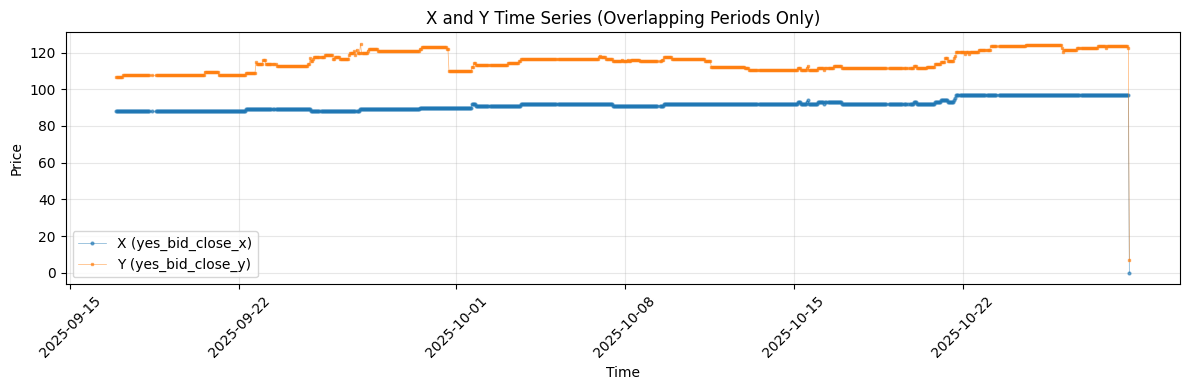

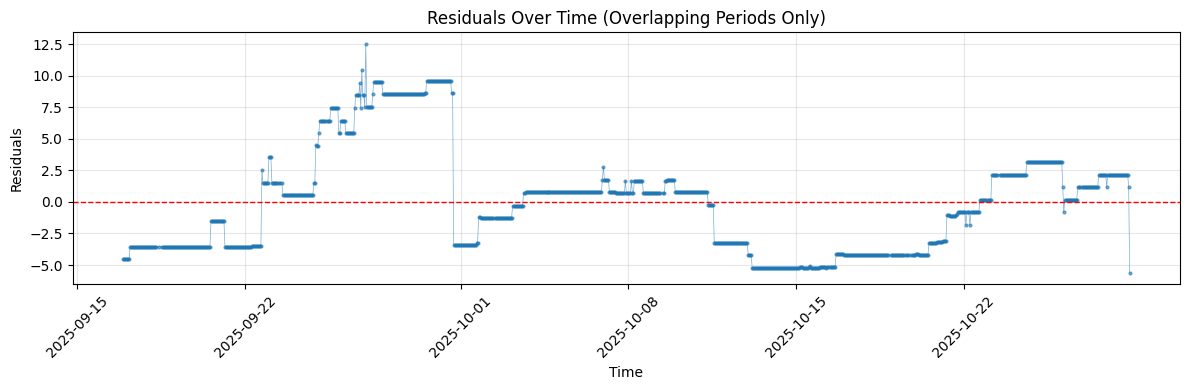


Trading opportunities (nonzero residuals in overlapping periods): 989
Percentage of overlapping periods with trades: 100.00%

Sample trading signals (first 10):
                   end_time  yes_bid_close_x  yes_bid_close_y  residual
0 2025-09-16 22:00:00+00:00             88.0            106.6 -4.549045
1 2025-09-16 23:00:00+00:00             88.0            106.6 -4.549045
2 2025-09-17 00:00:00+00:00             88.0            106.6 -4.549045
3 2025-09-17 01:00:00+00:00             88.0            106.6 -4.549045
4 2025-09-17 02:00:00+00:00             88.0            106.6 -4.549045
5 2025-09-17 03:00:00+00:00             88.0            106.6 -4.549045
6 2025-09-17 04:00:00+00:00             88.0            106.6 -4.549045
7 2025-09-17 05:00:00+00:00             88.0            107.6 -3.549045
8 2025-09-17 06:00:00+00:00             88.0            107.6 -3.549045
9 2025-09-17 07:00:00+00:00             88.0            107.6 -3.549045


In [59]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Fit linear regression model on overlapping periods only
X_overlap = df_overlap['yes_bid_close_x'].values.reshape(-1, 1)
y_overlap = df_overlap['yes_bid_close_y'].values

reg = LinearRegression()
reg.fit(X_overlap, y_overlap)

# Calculate residuals for ALL aligned time points
X_all = df_aligned['yes_bid_close_x'].values.reshape(-1, 1)
y_all = df_aligned['yes_bid_close_y'].values
y_pred_all = reg.predict(X_all)
residuals_all = y_all - y_pred_all

# Add residuals to aligned dataframe
df_aligned['residual'] = residuals_all
df_aligned['y_pred'] = y_pred_all

# Plot X and Y time series
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
overlap_data = df_aligned[df_aligned['is_overlap']].copy()
ax.plot(overlap_data['end_time'], overlap_data['yes_bid_close_x'], 
        label='X (yes_bid_close_x)', marker='o', markersize=2, linewidth=0.5, alpha=0.6)
ax.plot(overlap_data['end_time'], overlap_data['yes_bid_close_y'], 
        label='Y (yes_bid_close_y)', marker='s', markersize=2, linewidth=0.5, alpha=0.6)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('X and Y Time Series (Overlapping Periods Only)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Plot residuals over time for overlapping periods
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Residuals over time (only overlapping periods)
overlap_residuals = df_aligned[df_aligned['is_overlap']].copy()
ax.plot(overlap_residuals['end_time'], overlap_residuals['residual'], 
        marker='o', markersize=2, linewidth=0.5, alpha=0.6)
ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Time')
ax.set_ylabel('Residuals')
ax.set_title('Residuals Over Time (Overlapping Periods Only)')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Trading logic: identify periods with nonzero residuals
# For overlapping periods, generate trading signals
df_aligned['trade_signal'] = 0  # 0 = no trade, 1 = trade
df_aligned.loc[df_aligned['is_overlap'] & (df_aligned['residual'] != 0), 'trade_signal'] = 1

# Count trading opportunities
trade_count = df_aligned['trade_signal'].sum()
print(f"\nTrading opportunities (nonzero residuals in overlapping periods): {trade_count}")
print(f"Percentage of overlapping periods with trades: {trade_count / len(df_overlap) * 100:.2f}%")

# Show some example trading signals
print("\nSample trading signals (first 10):")
print(df_aligned[df_aligned['trade_signal'] == 1][['end_time', 'yes_bid_close_x', 'yes_bid_close_y', 'residual']].head(10))
